In [1]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [103]:
import numpy as np
import matplotlib as plt
import time
import os
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import cv2
from torchvision import transforms
from torchvision.utils import make_grid
from collections import OrderedDict
from PIL import Image,ImageOps
import torch.optim as optim
import scipy
from skimage import color

In [3]:
USE_CUDA = True # or False if you don't have CUDA.
FEATURE_IDS = [1, 6, 11, 20, 29]

imgS_path = './image/city_basic.jpg'
imgR_path = './image/city_night.jpg'

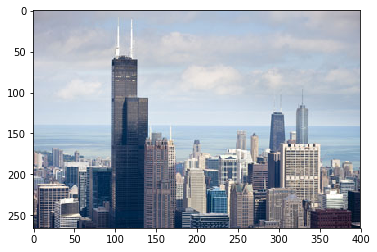

In [4]:
# Checking
origS = Image.open(imgS_path).convert("RGB")
imshow(origS)

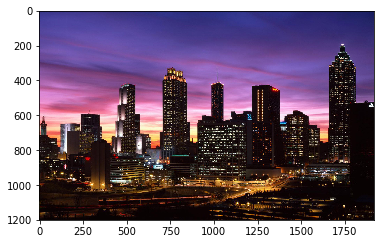

In [5]:
# Checking
origR = Image.open(imgR_path).convert("RGB")
imshow(origR)

In [6]:
def image_loader(img_path, flip=False):
    img = Image.open(img_path).convert("RGB")
    if flip:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = data_transforms(img)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

def npshow(img):
    img_np = img.numpy().transpose(1, 2, 0)
    imshow(img_np) #, interpolation = 'nearest')

In [7]:
imgS=image_loader(imgS_path, flip=False)
imgR=image_loader(imgR_path, flip=False)

imgS_np = imgS.squeeze().numpy().transpose(1, 2, 0)
imgR_np = imgR.squeeze().numpy().transpose(1, 2, 0)

In [8]:
# Checking
print(imgS.size()) # (1, 3, SHeight, SWidth)
print(imgR.size()) # (1, 3, RHeight, RWidth)
print(imgS.dtype, imgR.dtype, "\n") # torch.float32

print(imgS_np.shape) # (SHeight, SWidth, 3)
print(imgR_np.shape, "\n") # (RHeight, RWidth, 3)

# Verifying normalization
print("Original S's mean:", np.asarray(origS).mean(axis=(0, 1)))
print("Original S's std:", np.asarray(origS).std(axis=(0, 1)))
print("Normalized S's mean:", imgS_np.mean(axis=(0, 1)))
print("Normalized S's std:", imgS_np.std(axis=(0, 1)), "\n")

print("Original R's mean:", np.asarray(origR).mean(axis=(0, 1)))
print("Original R's std:", np.asarray(origR).std(axis=(0, 1)))
print("Normalized R's mean:", imgR_np.mean(axis=(0, 1)))
print("Normalized R's std:", imgR_np.std(axis=(0, 1)))

torch.Size([1, 3, 266, 400])
torch.Size([1, 3, 1200, 1920])
torch.float32 torch.float32 

(266, 400, 3)
(1200, 1920, 3) 

Original S's mean: [156.07516917 164.98545113 178.04074248]
Original S's std: [60.28188864 57.59120663 53.13235746]
Normalized S's mean: [0.5548449 0.8526866 1.2986623]
Normalized S's std: [1.0323125 1.0082494 0.9260542] 

Original R's mean: [81.58577387 56.06960677 84.69521528]
Original R's std: [67.95775321 51.31118997 73.64343419]
Normalized R's mean: [-0.7207675  -1.0541035  -0.32827505]
Normalized R's std: [1.16376    0.89830506 1.2835457 ]


In [9]:
#(512 14 14)  imgR = 3 224 224    reR = 512 14 14
def image_to_tensor(img, img_transforms = []):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    transform = transforms.Compose(img_transforms + [
        transforms.ToTensor(),

    ])
    return transform(img)

def resized_R(self, size):
        return image_to_tensor(origR, [transforms.Resize(size)])
def resized_S(self,size):
        return image_to_tensor(origS,[transforms.Resize(size)])

In [13]:
rsR = resized_R(origR, [75,120])
print(rsR.shape)

torch.Size([3, 75, 120])


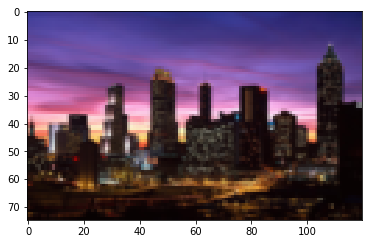

In [17]:
npshow(rsR)

In [149]:
rsS = resized_S(origS, [75,120])
print(rsS.shape)

torch.Size([3, 75, 120])


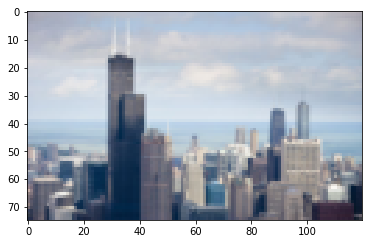

In [150]:
npshow(rsS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


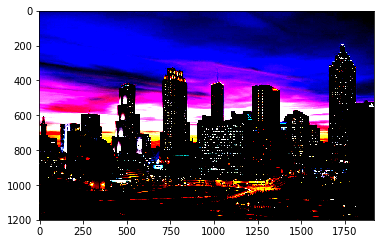

In [20]:
imshow(imgR_np)

In [21]:
imgR_np.shape

(1200, 1920, 3)

In [84]:
scaleH = imgR_np.shape[0]/rsR.shape[1]
print(scaleH)
scaleW = imgR_np.shape[1]/rsR.shape[2]
print(scaleW) #### same for W, H

scale = (imgR_np.shape[0]/rsR.shape[1])

16.0
16.0


In [65]:
rsR.shape[1:]

torch.Size([75, 120])

In [90]:
def _upSample(I, scale, shape=None):
    h, w = I.shape[:2]
    return cv2.resize(I, (w * scale, h * scale), interpolation=cv2.INTER_LINEAR)

In [86]:
rsRnp = rsR.squeeze().numpy().transpose(1,2,0)
print(rsRnp.shape)

(75, 120, 3)


In [91]:
upR = _upSample(rsRnp,16)
upR.shape

(1200, 1920, 3)

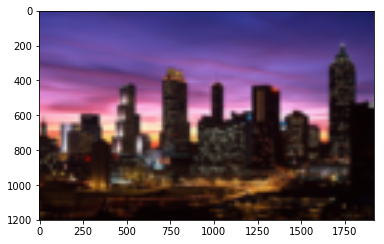

In [94]:
imshow(upR)

In [145]:
rsimgR = resized_R(imgR_np,[75,120])
print(rsimgR.shape)

torch.Size([3, 75, 120])


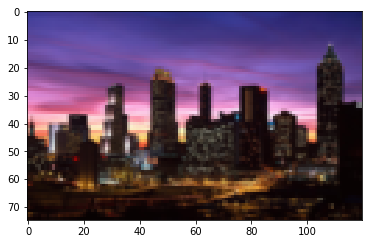

In [146]:
npshow(rsimgR)

In [108]:
rsR.unsqueeze(0).shape

torch.Size([1, 3, 75, 120])

In [141]:
rsR.permute(1,2,0).unsqueeze(0).shape

torch.Size([1, 75, 120, 3])

In [115]:
TorigR = image_to_tensor(origR)
print(TorigR.shape)
print(TorigR.unsqueeze(0).shape)

torch.Size([3, 1200, 1920])
torch.Size([1, 3, 1200, 1920])


In [151]:
from guided_filter_pytorch.guided_filter import FastGuidedFilter
##hr_y = FastGuidedFilter(r, eps)(lr_x, lr_y, hr_x) -> high resolution output = radius, epsilon, lowres input, ~
hr_y = FastGuidedFilter(1, 1e-8)(rsR.unsqueeze(0), #low resolution input
                                 rsS.unsqueeze(0),  #low resolution output
                                 TorigR.unsqueeze(0)) #high resolution input
print(hr_y.shape)

torch.Size([1, 3, 1200, 1920])


/home/dongjun/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dongjun/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


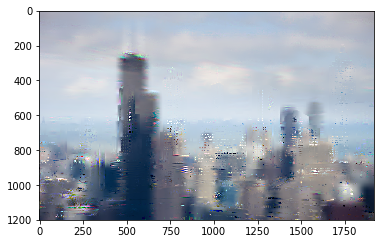

In [152]:
imshow(hr_y.squeeze().numpy().transpose(1,2,0))

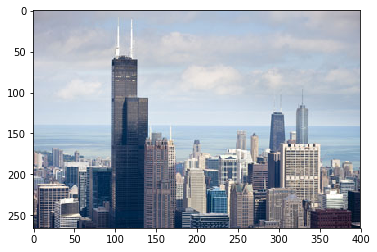

In [153]:
imshow(origS)

In [ ]:
#####working on https://github.com/tody411/GuidedFilter/blob/master/guided_filter/core/filters.py
###### wait
#class FastGuidedFilter:
    ## Constructor.
    #  @param I Input guidance image. Color or gray.
    #  @param radius Radius of Guided Filter.
    #  @param epsilon Regularization term of Guided Filter.
    #  @param scale Down sampled scale.
    def __init__(self, I, radius=5, epsilon=0.4, scale=4):
        I_32F = to32F(I)
        self._I = I_32F
        h, w = I.shape[:2]

        I_sub = _downSample(I_32F, scale)

        self._I_sub = I_sub
        radius = int(radius / scale)

        if _isGray(I):
            self._guided_filter = GuidedFilterGray(I_sub, radius, epsilon)
        else:
            self._guided_filter = GuidedFilterColor(I_sub, radius, epsilon)

    ## Apply filter for the input image.
    #  @param p Input image for the filtering.
    def filter(self, p):
        p_32F = to32F(p)
        shape_original = p.shape[:2]

        p_sub = _downSample(p_32F, shape=self._I_sub.shape[:2])

        if _isGray(p_sub):
            return self._filterGray(p_sub, shape_original)

        cs = p.shape[2]
        q = np.array(p_32F)

        for ci in range(cs):
            q[:, :, ci] = self._filterGray(p_sub[:, :, ci], shape_original)
        return q

    def _filterGray(self, p_sub, shape_original):
        ab_sub = self._guided_filter._computeCoefficients(p_sub)
        ab = [_upSample(abi, shape=shape_original) for abi in ab_sub]
        return self._guided_filter._computeOutput(ab, self._I)


## Guide filter.
class GuidedFilter:
    ## Constructor.
    #  @param I Input guidance image. Color or gray.
    #  @param radius Radius of Guided Filter.
    #  @param epsilon Regularization term of Guided Filter.
    def __init__(self, I, radius=5, epsilon=0.4):
        I_32F = to32F(I)

        if _isGray(I):
            self._guided_filter = GuidedFilterGray(I_32F, radius, epsilon)
        else:
            self._guided_filter = GuidedFilterColor(I_32F, radius, epsilon)

    ## Apply filter for the input image.
    #  @param p Input image for the filtering.
    def filter(self, p):
        return self._guided_filter.filter(p)


## Common parts of guided filter.
#
#  This class is used by guided_filter class. GuidedFilterGray and GuidedFilterColor.
#  Based on guided_filter._computeCoefficients, guided_filter._computeOutput,
#  GuidedFilterCommon.filter computes filtered image for color and gray.
class GuidedFilterCommon:
    def __init__(self, guided_filter):
        self._guided_filter = guided_filter

    ## Apply filter for the input image.
    #  @param p Input image for the filtering.
    def filter(self, p):
        p_32F = to32F(p)
        if _isGray(p_32F):
            return self._filterGray(p_32F)

        cs = p.shape[2]
        q = np.array(p_32F)

        for ci in range(cs):
            q[:, :, ci] = self._filterGray(p_32F[:, :, ci])
        return q

    def _filterGray(self, p):
        ab = self._guided_filter._computeCoefficients(p)
        return self._guided_filter._computeOutput(ab, self._guided_filter._I)


## Guided filter for gray guidance image.
class GuidedFilterGray:
    #  @param I Input gray guidance image.
    #  @param radius Radius of Guided Filter.
    #  @param epsilon Regularization term of Guided Filter.
    def __init__(self, I, radius=5, epsilon=0.4):
        self._radius = 2 * radius + 1
        self._epsilon = epsilon
        self._I = to32F(I)
        self._initFilter()
        self._filter_common = GuidedFilterCommon(self)

    ## Apply filter for the input image.
    #  @param p Input image for the filtering.
    def filter(self, p):
        return self._filter_common.filter(p)

    def _initFilter(self):
        I = self._I
        r = self._radius
        self._I_mean = cv2.blur(I, (r, r))
        I_mean_sq = cv2.blur(I ** 2, (r, r))
        self._I_var = I_mean_sq - self._I_mean ** 2

    def _computeCoefficients(self, p):
        r = self._radius
        p_mean = cv2.blur(p, (r, r))
        p_cov = p_mean - self._I_mean * p_mean
        a = p_cov / (self._I_var + self._epsilon)
        b = p_mean - a * self._I_mean
        a_mean = cv2.blur(a, (r, r))
        b_mean = cv2.blur(b, (r, r))
        return a_mean, b_mean

    def _computeOutput(self, ab, I):
        a_mean, b_mean = ab
        return a_mean * I + b_mean


## Guided filter for color guidance image.
class GuidedFilterColor:
    #  @param I Input color guidance image.
   #  @param radius Radius of Guided Filter.
    #  @param epsilon Regularization term of Guided Filter.
    def __init__(self, I, radius=5, epsilon=0.2):
        self._radius = 2 * radius + 1
        self._epsilon = epsilon
        self._I = to32F(I)
        self._initFilter()
        self._filter_common = GuidedFilterCommon(self)

    ## Apply filter for the input image.
    #  @param p Input image for the filtering.
    def filter(self, p):
        return self._filter_common.filter(p)

    def _initFilter(self):
        I = self._I
        r = self._radius
        eps = self._epsilon

        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]

        self._Ir_mean = cv2.blur(Ir, (r, r))
        self._Ig_mean = cv2.blur(Ig, (r, r))
        self._Ib_mean = cv2.blur(Ib, (r, r))

        Irr_var = cv2.blur(Ir ** 2, (r, r)) - self._Ir_mean ** 2 + eps
        Irg_var = cv2.blur(Ir * Ig, (r, r)) - self._Ir_mean * self._Ig_mean
        Irb_var = cv2.blur(Ir * Ib, (r, r)) - self._Ir_mean * self._Ib_mean
        Igg_var = cv2.blur(Ig * Ig, (r, r)) - self._Ig_mean * self._Ig_mean + eps
        Igb_var = cv2.blur(Ig * Ib, (r, r)) - self._Ig_mean * self._Ib_mean
        Ibb_var = cv2.blur(Ib * Ib, (r, r)) - self._Ib_mean * self._Ib_mean + eps

        Irr_inv = Igg_var * Ibb_var - Igb_var * Igb_var
        Irg_inv = Igb_var * Irb_var - Irg_var * Ibb_var
        Irb_inv = Irg_var * Igb_var - Igg_var * Irb_var
        Igg_inv = Irr_var * Ibb_var - Irb_var * Irb_var
        Igb_inv = Irb_var * Irg_var - Irr_var * Igb_var
        Ibb_inv = Irr_var * Igg_var - Irg_var * Irg_var

        I_cov = Irr_inv * Irr_var + Irg_inv * Irg_var + Irb_inv * Irb_var
        Irr_inv /= I_cov
        Irg_inv /= I_cov
        Irb_inv /= I_cov
        Igg_inv /= I_cov
        Igb_inv /= I_cov
        Ibb_inv /= I_cov

        self._Irr_inv = Irr_inv
        self._Irg_inv = Irg_inv
        self._Irb_inv = Irb_inv
        self._Igg_inv = Igg_inv
        self._Igb_inv = Igb_inv
        self._Ibb_inv = Ibb_inv

    def _computeCoefficients(self, p):
        r = self._radius
        I = self._I
        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]

        p_mean = cv2.blur(p, (r, r))

        Ipr_mean = cv2.blur(Ir * p, (r, r))
        Ipg_mean = cv2.blur(Ig * p, (r, r))
        Ipb_mean = cv2.blur(Ib * p, (r, r))

        Ipr_cov = Ipr_mean - self._Ir_mean * p_mean
        Ipg_cov = Ipg_mean - self._Ig_mean * p_mean
        Ipb_cov = Ipb_mean - self._Ib_mean * p_mean

        ar = self._Irr_inv * Ipr_cov + self._Irg_inv * Ipg_cov + self._Irb_inv * Ipb_cov
        ag = self._Irg_inv * Ipr_cov + self._Igg_inv * Ipg_cov + self._Igb_inv * Ipb_cov
        ab = self._Irb_inv * Ipr_cov + self._Igb_inv * Ipg_cov + self._Ibb_inv * Ipb_cov
        b = p_mean - ar * self._Ir_mean - ag * self._Ig_mean - ab * self._Ib_mean

        ar_mean = cv2.blur(ar, (r, r))
        ag_mean = cv2.blur(ag, (r, r))
        ab_mean = cv2.blur(ab, (r, r))
        b_mean = cv2.blur(b, (r, r))

        return ar_mean, ag_mean, ab_mean, b_mean

    def _computeOutput(self, ab, I):
        ar_mean, ag_mean, ab_mean, b_mean = ab

        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]

        q = (ar_mean * Ir +
             ag_mean * Ig +
             ab_mean * Ib +
             b_mean)

        return q